# Import Frameworks and Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Read the Dataset using Pandas

In [2]:
data = pd.read_csv('Data/ratings.csv')
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Create train and test data

In [3]:
train, test = train_test_split(data, test_size=0.05, random_state=42)

In [4]:
train.head()

,userId,movieId,rating,timestamp
39561,274,2004,4.0,1197015180
11758,71,1210,3.0,864738037
61956,410,3161,4.0,990727962
16361,105,3968,3.0,1446750055
69986,448,90522,2.0,1356205855


In [5]:
test.head()

,userId,movieId,rating,timestamp
67037,432,77866,4.5,1335139641
42175,288,474,3.0,978465565
93850,599,4351,3.0,1498524542
6187,42,2987,4.0,996262677
12229,75,1610,4.0,1158989841


In [6]:
num_users = data.userId.unique().shape[0]
num_items = data.movieId.unique().shape[0]
print("Number of users = ", num_users)
print("Number of items = ", num_items)

Number of users =  610
Number of items =  9724


# 2. Matrix Factorization Model

In [7]:
users, items, _, _ = data.max(axis=0)
users, items = int(users), int(items)

In [8]:
class MatrixFactorization_Layer(tf.keras.layers.Layer):
    def __init__(self, embedding_size, num_users, num_items):
        super(MatrixFactorization_Layer, self).__init__()
        self.embedding_size = embedding_size
        self.num_users = num_users
        self.num_items = num_items
        
        self.P = Embedding(input_dim=self.num_users+1, output_dim=self.embedding_size, name='Embedding_P')
        self.Q = Embedding(input_dim=self.num_items+1, output_dim=self.embedding_size, name='Embedding_Q')
        self.flatten = Flatten()
        self.user_bias = Embedding(self.num_users+1, 1, name='user_bias')
        self.item_bias = Embedding(self.num_items+1, 1, name='item_bias')
        self.dot = tf.keras.layers.Dot(axes=1)
        
    def call(self, input_):
        user_id_ = input_[0]
        item_id_ = input_[1]
        P_u = self.P(user_id_)
        Q_i = self.Q(item_id_)
        b_u = self.user_bias(user_id_)
        b_i = self.item_bias(item_id_)
        outputs = self.dot([P_u, Q_i]) + b_u + b_i
        outputs = self.flatten(outputs)
        return outputs

In [9]:
class MatrixFactorization_Model(tf.keras.Model):
    def __init__(self, embedding_size, num_users, num_items):
        super(MatrixFactorization_Model, self).__init__()
        self.embedding_size = embedding_size
        self.MF = MatrixFactorization_Layer(self.embedding_size, num_users, num_items)
        
    def call(self, inputs):
        x = self.MF(inputs)
        return x
    
    def model(self):
        x = Input(batch_input_shape=(None, self.embedding_size), name="Input_Layer")
        return Model(inputs=[x], outputs=self.call(x))

In [10]:
model = MatrixFactorization_Model(5, users, items)

2021-09-22 01:14:56.011979: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
optimizer = Adam(learning_rate=0.001)
loss_object = MeanSquaredError()
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.0001)

In [12]:
model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])

In [13]:
model.model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 5)]               0         
_________________________________________________________________
matrix_factorization__layer  (5, 1)                    1165326   
Total params: 1,165,326
Trainable params: 1,165,326
Non-trainable params: 0
_________________________________________________________________


In [14]:
train_x = [train.iloc[:, 0], train.iloc[:, 1]]
train_y = train.iloc[:, 2]

history = model.fit(train_x, train_y, validation_split = 0.3,
                    epochs=100, batch_size=15, shuffle=True, callbacks=[callback])

Epoch 1/100


2021-09-22 01:14:56.431834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-22 01:14:56.454352: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494450000 Hz


4471/4471 [==============================] - 54s 12ms/step - loss: 11.1737 - accuracy: 0.0315 - val_loss: 5.4327 - val_accuracy: 0.0337
Epoch 2/100
4471/4471 [==============================] - 55s 12ms/step - loss: 4.2567 - accuracy: 0.0330 - val_loss: 2.2803 - val_accuracy: 0.0336
Epoch 3/100
4471/4471 [==============================] - 52s 12ms/step - loss: 1.8943 - accuracy: 0.0333 - val_loss: 1.4726 - val_accuracy: 0.0335
Epoch 4/100
4471/4471 [==============================] - 59s 13ms/step - loss: 1.2471 - accuracy: 0.0332 - val_loss: 1.1589 - val_accuracy: 0.0334
Epoch 5/100
4471/4471 [==============================] - 65s 14ms/step - loss: 0.9745 - accuracy: 0.0318 - val_loss: 1.0090 - val_accuracy: 0.0334
Epoch 6/100
4471/4471 [==============================] - 60s 13ms/step - loss: 0.8380 - accuracy: 0.0345 - val_loss: 0.9285 - val_accuracy: 0.0336
Epoch 7/100
4471/4471 [==============================] - 59s 13ms/step - loss: 0.7645 - accuracy: 0.0336 - val_loss: 0.8829 - val

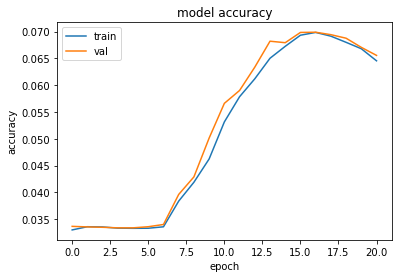

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

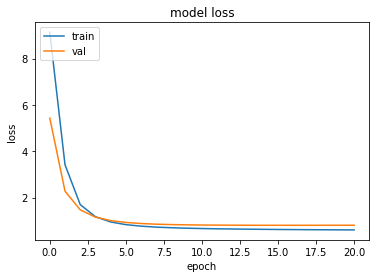

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
evaluation = model.evaluate([test.iloc[:, 0], test.iloc[:, 1]], test.iloc[:, 2])

158/158 [==============================] - 0s 696us/step - loss: 0.8503 - accuracy: 0.0716
